## Content
#### 1 Introduction
#### 2 Configuring the detectron2 module and runtime environment
#### 3 Get the Centermask2 repository
#### 4 Writing configuration and training codes
#### 5 Register coco datasets
#### 6 Train and evalute the model
#### 7 Evaluation
#### 8 Prediction

#### 1 Introduction
[CenterMask2](https://github.com/youngwanLEE/centermask2) using [Detectron2](https://github.com/facebookresearch/detectron2) library perform well in object detection and instance segmentation, and the paper also demonstrates good results on the Livecell dataset, so CenterMask2 and Detectron2 are used as training frameworks to select appropriate variants and adjust hyperparameters for cell instance segmentation and prediction.

#### 2 Configuring the detectron2 module and runtime environment
Version compatibility between pytorch and cuda is important, as it is a precondition for detectron2 to install and run. 
The original cuda of kaggle is not suitable for detectron2, so uninstall it first and then install the new version.  
For more information, please see [Detectron2 Tutorials](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html).

In [1]:
#Install the appropriate detectron2 version according to the existing pytorch and cuda versions
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

# Install detectron2 offline
!pip install --no-index /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/detectron2-0.6-cp37-cp37m-linux_x86_64.whl --find-links=/kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION, "cuda_available: ", torch.cuda.is_available() )

# Get the CUDA version
# The GPU needs to be enabled for this to work.
# The CUDA version is in the top right corner.
!nvcc --version
!nvidia-smi

torch:  1.9 ; cuda:  1.9.1
Looking in links: /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/detectron2-0.6-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/black-21.4b2-py3-none-any.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/omegaconf-2.1.1-py3-none-any.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/hydra_core-1.1.1-py3-none-any.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/fvcore-0.1.5.post20211023-py3-none-any.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/iopath-0.1.9-py3-none-any.whl
Processing /kaggle/input/detectron2

#### 3 Get the CenterMask2 Repository
clone CenterMask2 repo and download one of the pretrained variants, add the repo as a datasets. 
The model size, average precision and specific parameter files can be seen in the CenterMask2 [repo](https://github.com/youngwanLEE/centermask2). Taking into account the average precision and computing time, a lightweight model is tested first.

In [2]:
%cd /kaggle/input/centermask2litev19slim13000

/kaggle/input/centermask2litev19slim13000


#### 4 Writing configuration and training codes
To write the **configuration** file, refer to the  
detectron2 repo:  [detectron2/detectron2/config/defaults.py](https://github.com/facebookresearch/detectron2/blob/main/detectron2/config/defaults.py)  
and CenterMask2 repo: [centermask2/centermask/config/defaults.py](https://github.com/youngwanLEE/centermask2/blob/master/centermask/config/defaults.py) 

In [3]:
%%writefile /kaggle/working/test.yaml
# Copyright (c) Facebook, Inc. and its affiliates.
# Copyright (c) Youngwan Lee (ETRI) All Rights Reserved.

CUDNN_BENCHMARK: false
DATALOADER:
    NUM_WORKERS: 4
    ASPECT_RATIO_GROUPING: true
    FILTER_EMPTY_ANNOTATIONS: true
    SAMPLER_TRAIN: TrainingSampler
    REPEAT_THRESHOLD: 0.0
MODEL:
    ANCHOR_GENERATOR:
        NAME: DefaultAnchorGenerator
    META_ARCHITECTURE: "GeneralizedRCNN"
    DEVICE: cuda
    KEYPOINT_ON: false
    BACKBONE:
        NAME: "build_fcos_vovnet_fpn_backbone"
        FREEZE_AT: 0
    VOVNET:
        OUT_FEATURES: ["stage3", "stage4", "stage5"]
    FPN:
        IN_FEATURES: ["stage3", "stage4", "stage5"]
    PROPOSAL_GENERATOR:
        NAME: "FCOS"  
    FCOS:
        POST_NMS_TOPK_TEST: 800 
        POST_NMS_TOPK_TRAIN: 800
    MASK_ON: True
    MASKIOU_ON: True
    ROI_HEADS:
        NAME: "CenterROIHeads"
        IN_FEATURES: ["p3", "p4", "p5"]
    ROI_MASK_HEAD:
        NAME: "SpatialAttentionMaskHead"
        ASSIGN_CRITERION: "ratio"
        NUM_CONV: 4
        POOLER_RESOLUTION: 14
        POOLER_SAMPLING_RATIO: 0
#The datasets must be registered as coco dasets and have the same name as here
DATASETS:
    TRAIN: ("train",) 
    TEST: ("test",)
INPUT:
    MIN_SIZE_TRAIN: (480, 512, 640)
TEST:
    AUG:
        ENABLED: False
    DETECTIONS_PER_IMAGE: 600
    EVAL_PERIOD: 600
SOLVER:
    CHECKPOINT_PERIOD: 5000
    IMS_PER_BATCH: 8
    BASE_LR: 0.01  
    STEPS: (60000, 80000)
    LR_SCHEDULER_NAME: WarmupMultiStepLR
    MAX_ITER: 12000 #1000 iterations ≈ 25 mins, temporarily set at 18,000 iterations within 9 hours, 

Writing /kaggle/working/test.yaml


To write the **Training** codes, refer to CenterMask2 repo [train_net.py](https://github.com/youngwanLEE/centermask2/blob/master/train_net.py)

In [4]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
# Modified by Youngwan Lee (ETRI), 2020. All Rights Reserved.

# Some basic setup:
import detectron2
import logging
import os
from collections import OrderedDict
import torch
import numpy as np
import os, json, cv2, random, re

import detectron2.utils.comm as comm
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances, load_coco_json
from detectron2.engine import DefaultTrainer, DefaultPredictor, default_argument_parser, default_setup, hooks, launch
from detectron2.evaluation import (
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    verify_results,
)

import os
import sys
module_path = os.path.abspath(os.path.join('../input/centermask2litev19slim13000'))
if module_path not in sys.path:
    sys.path.append(module_path)
from centermask.evaluation import (
    COCOEvaluator,
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator
)

#import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.modeling import GeneralizedRCNNWithTTA
from detectron2.checkpoint import DetectionCheckpointer
from centermask.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

class Trainer(DefaultTrainer):
    """
    This is the same Trainer except that we rewrite the
    `build_train_loader` method.
    """

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """
        Create evaluator(s) for a given dataset.
        This uses the special metadata "evaluator_type" associated with each builtin dataset.
        For your own dataset, you can simply create an evaluator manually in your
        script and do not have to worry about the hacky if-else logic here.

        :param cls: classes
        :param cfg: configs
        :param dataset_name: name of dataset
        :param output_folder: folder that saves output data
        """
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        evaluator_list = []
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
        evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
        if len(evaluator_list) == 0:
            raise NotImplementedError(
                "no Evaluator for the dataset {} with the type {}".format(
                    dataset_name, evaluator_type
                )
            )
        elif len(evaluator_list) == 1:
            return evaluator_list[0]
        return DatasetEvaluators(evaluator_list)

    @classmethod
    def test_with_TTA(cls, cfg, model):
        logger = logging.getLogger("detectron2.trainer")
        # In the end of training, run an evaluation with TTA
        # Only support some R-CNN models.
        logger.info("Running inference with test-time augmentation ...")
        model = GeneralizedRCNNWithTTA(cfg, model)
        evaluators = [
            cls.build_evaluator(
                cfg, name, output_folder=os.path.join(cfg.OUTPUT_DIR, "inference_TTA")
            )
            for name in cfg.DATASETS.TEST
        ]
        res = cls.test(cfg, model, evaluators)
        res = OrderedDict({k + "_TTA": v for k, v in res.items()})
        return res

def setup(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    default_setup(cfg, args)
    return cfg


def main(args):
    cfg = setup(args)

    if args.eval_only:
        model = Trainer.build_model(cfg)
        DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
            cfg.MODEL.WEIGHTS, resume=args.resume
        )
        res = Trainer.test(cfg, model)
        if cfg.TEST.AUG.ENABLED:
            res.update(Trainer.test_with_TTA(cfg, model))
        if comm.is_main_process():
            verify_results(cfg, res)
        return res

    """
    If you'd like to do anything fancier than the standard training logic,
    consider writing your own training loop or subclassing the trainer.
    """
    trainer = Trainer(cfg)
    trainer.resume_or_load(resume=args.resume)
    if cfg.TEST.AUG.ENABLED:
        trainer.register_hooks(
            [hooks.EvalHook(0, lambda: trainer.test_with_TTA(cfg, trainer.model))]
        )
    return trainer.train()

Set the configuration for the model.  
It will conduct training and evaluation.

In [5]:
cfg = get_cfg()
%cd /kaggle/working
cfg.merge_from_file("./test.yaml")
cfg.freeze()
default_setup(cfg, 'Namespace(num_gpus=1, opts=[\'MODEL.WEIGHTS\', \'centermask_lite_V_39_eSE_FPN_ms_4x.pth\'], resume=False')

/kaggle/working
[12/25 20:36:20 detectron2]: Rank of current process: 0. World size: 1
[12/25 20:36:22 detectron2]: Environment info:
----------------------  -------------------------------------------------------------------------------
sys.platform            linux
Python                  3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) [GCC 9.4.0]
numpy                   1.19.5
detectron2              0.6 @/opt/conda/lib/python3.7/site-packages/detectron2
Compiler                GCC 7.5
CUDA compiler           CUDA 11.0
detectron2 arch flags   6.0
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.1 @/opt/conda/lib/python3.7/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   Tesla P100-PCIE-16GB (arch=6.0)
Driver version          450.119.04
CUDA_HOME               /usr/local/cuda
Pillow                  8.2.0
torchvision             0.10.1 @/opt/conda/lib/python3.7/site-packages/torchvision
torchvision 

#### 5 Register coco datasets

How to register coco datasets, refer to:  
[Use Custom Datasets](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html)  
[Use Builtin Datasets](https://github.com/facebookresearch/detectron2/tree/main/datasets)  
cell-clean-astro-mask datasets is from [Sartorius: Create COCO annotations](https://www.kaggle.com/mistag/sartorius-create-coco-annotations/data) by GEIR DRANGE 

In [6]:
# Dataset registration
from detectron2.data.datasets import register_coco_instances

register_coco_instances('train', {}, 
                       '/kaggle/input/cellcleanastromask/train_fold_0.json',
                        '/kaggle/input/sartorius-cell-instance-segmentation/train')
register_coco_instances('test', {}, 
                        '/kaggle/input/cellcleanastromask/test_fold_0.json',
                        '/kaggle/input/sartorius-cell-instance-segmentation/test')

CLASSES = ["shsy5y", "astro", "cort"]
MetadataCatalog.get("train").thing_classes = CLASSES
MetadataCatalog.get("train").evaluator_type = "coco"
MetadataCatalog.get("test").thing_classes = CLASSES
MetadataCatalog.get("test").evaluator_type = "coco"

[12/25 20:36:23 d2.data.datasets.coco]: Loaded 122 images in COCO format from /kaggle/input/cellcleanastromask/test_fold_0.json


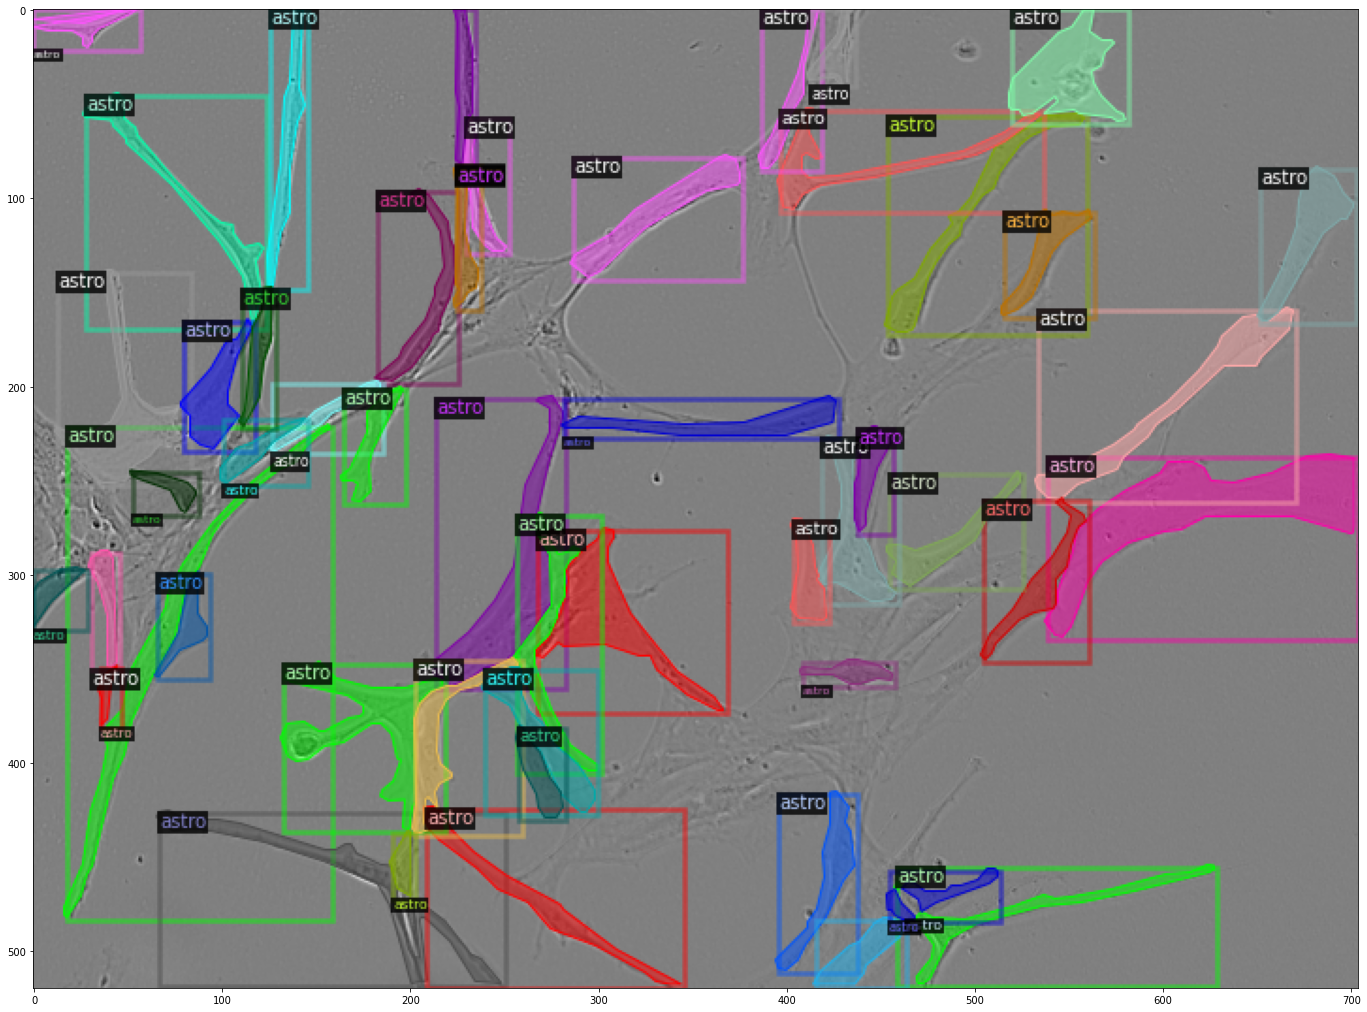

In [7]:
test_ds = DatasetCatalog.get('test')
meta_ds = MetadataCatalog.get("test")
test_sample = test_ds[25]
img = cv2.imread(test_sample["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=meta_ds)
output = visualizer.draw_dataset_dict(test_sample)

plt.figure(figsize = (24,18)) 
plt.imshow(output.get_image()[:, :, ::-1]);

#### 6 Train and evaluate the model
The previous configuration selected to train and evaluate the model with the default evaluator.

In [8]:
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
if cfg.TEST.AUG.ENABLED:
    trainer.register_hooks(
        [hooks.EvalHook(0, lambda: trainer.test_with_TTA(cfg, trainer.model))]
    )

#To avoid CUDA out-of-memory error, clear the cache in advance
torch.cuda.empty_cache()

trainer.train()

[12/25 20:36:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): VoVNet(
      (stem): Sequential(
        (stem_1/conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (stem_1/norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        (stem_1/relu): R

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[12/25 20:36:34 fvcore.common.checkpoint]: No checkpoint found. Initializing model from scratch
[12/25 20:36:34 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[12/25 20:37:12 d2.utils.events]:  eta: 4:45:10  iter: 19  total_loss: 3.13  loss_mask: 0.6931  loss_maskiou: 0.06124  loss_fcos_cls: 0.753  loss_fcos_loc: 0.8907  loss_fcos_ctr: 0.6935  time: 1.5176  data_time: 0.1032  lr: 0.00019981  max_mem: 14447M
[12/25 20:37:43 d2.utils.events]:  eta: 4:52:58  iter: 39  total_loss: 2.79  loss_mask: 0.693  loss_maskiou: 0.02432  loss_fcos_cls: 0.4551  loss_fcos_loc: 0.8961  loss_fcos_ctr: 0.6861  time: 1.5248  data_time: 0.0562  lr: 0.00039961  max_mem: 14447M
[12/25 20:38:13 d2.utils.events]:  eta: 4:52:29  iter: 59  total_loss: 2.759  loss_mask: 0.6927  loss_maskiou: 0.007886  loss_fcos_cls: 0.4534  loss_fcos_loc: 0.9099  loss_fcos_ctr: 0.6899  time: 1.5245  data_time: 0.0522  lr: 0.00059941  max_mem: 14447M
[12/25 20:38:43 d2.utils.events]:  eta: 4:53:51  iter: 79  total_loss: 2.742  loss_mask: 0.6924  loss_maskiou: 0.005438  loss_fcos_cls: 0.4588  loss_fcos_loc: 0.9013  loss_fcos_ctr: 0.6848  time: 1.5150  data_time: 0.0645  lr: 0.00079921  ma

#### 7 Evaluation
Analysis the learing process and visualization, code from [[train] Sartorius: Detectron2 + CenterMask2](https://www.kaggle.com/mistag/train-sartorius-detectron2-centermask2/notebook)

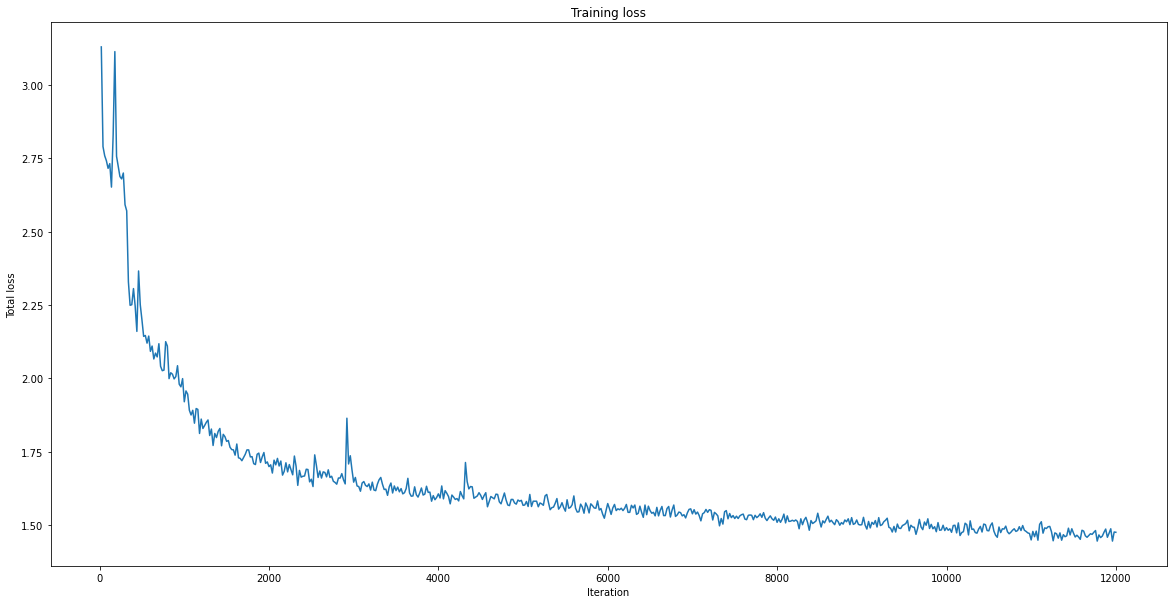

In [9]:
import re
# read log file
with open('./output/log.txt', 'r') as f:
    log = f.read()
# extract training loss
lines = re.findall('iter: [0-9]*  total_loss: [.0-9]*', log)
it, loss = [], []
for i in range(len(lines)):
    res = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", lines[i])
    it.append(int(res[0]))
    loss.append(float(res[1]))
plt.figure(figsize = (20,10))
plt.plot(it, loss)
plt.xlabel('Iteration')
plt.ylabel('Total loss')
plt.title('Training loss');

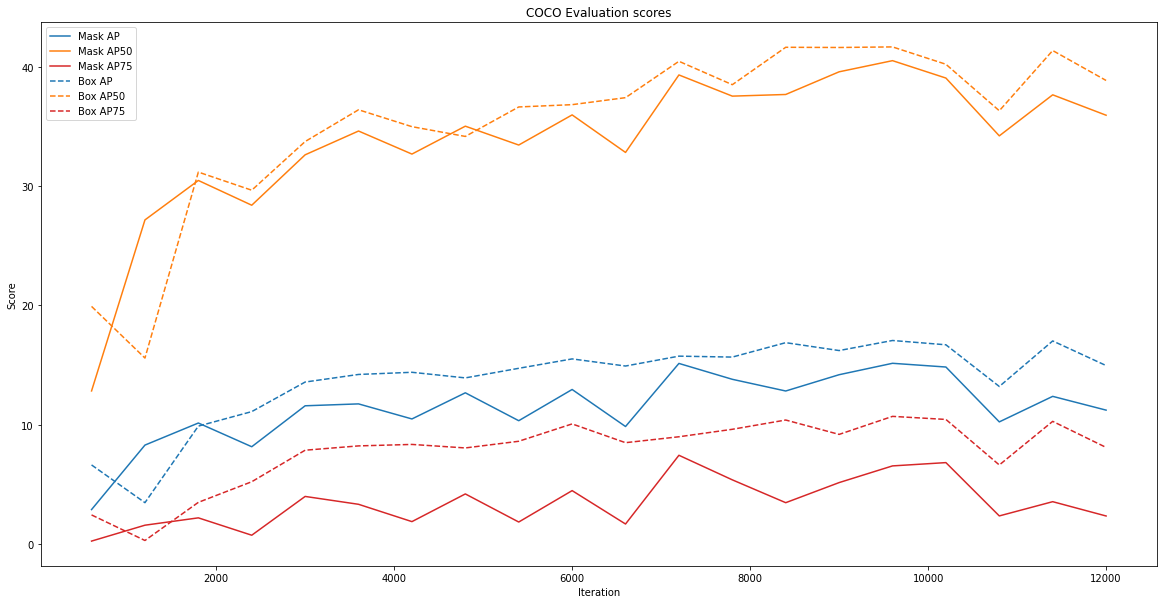

In [10]:
# Then we do evaluation scores
raw = re.findall('copypaste: [.,0-9]*', log)
boxes, segs = [], []
idx = 0
for s in raw:
    if len(s) > 20:
        nums = [float(i) for i in s.strip('copypaste: ').split(',')]
        if idx == 0:
            boxes.append(nums)
        else:
            segs.append(nums)
        idx = (idx + 1) % 2
boxes, segs = np.asarray(boxes), np.asarray(segs)
x = (np.arange(0, len(segs[:,0])) *600) + 600
plt.figure(figsize = (20,10))
x = (np.arange(0, len(segs[:,0])) *600) + 600
plt.plot(x, segs[:,0], label='Mask AP', color='tab:blue')
plt.plot(x, segs[:,1], label='Mask AP50', color='tab:orange')
plt.plot(x, segs[:,2], label='Mask AP75', color='tab:red')
plt.plot(x, boxes[:,0], label='Box AP', linestyle='--', color='tab:blue')
plt.plot(x, boxes[:,1], label='Box AP50', linestyle='--', color='tab:orange')
plt.plot(x, boxes[:,2], label='Box AP75', linestyle='--', color='tab:red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('COCO Evaluation scores');

#### 8 Prediction 
Check a few predictions, code from [Positive score with Detectron 2/3 - Training](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-2-3-training).

[12/26 02:59:35 fvcore.common.checkpoint]: [Checkpointer] Loading from ./output/model_final.pth ...
[12/26 02:59:35 d2.data.datasets.coco]: Loaded 122 images in COCO format from /kaggle/input/cellcleanastromask/test_fold_0.json


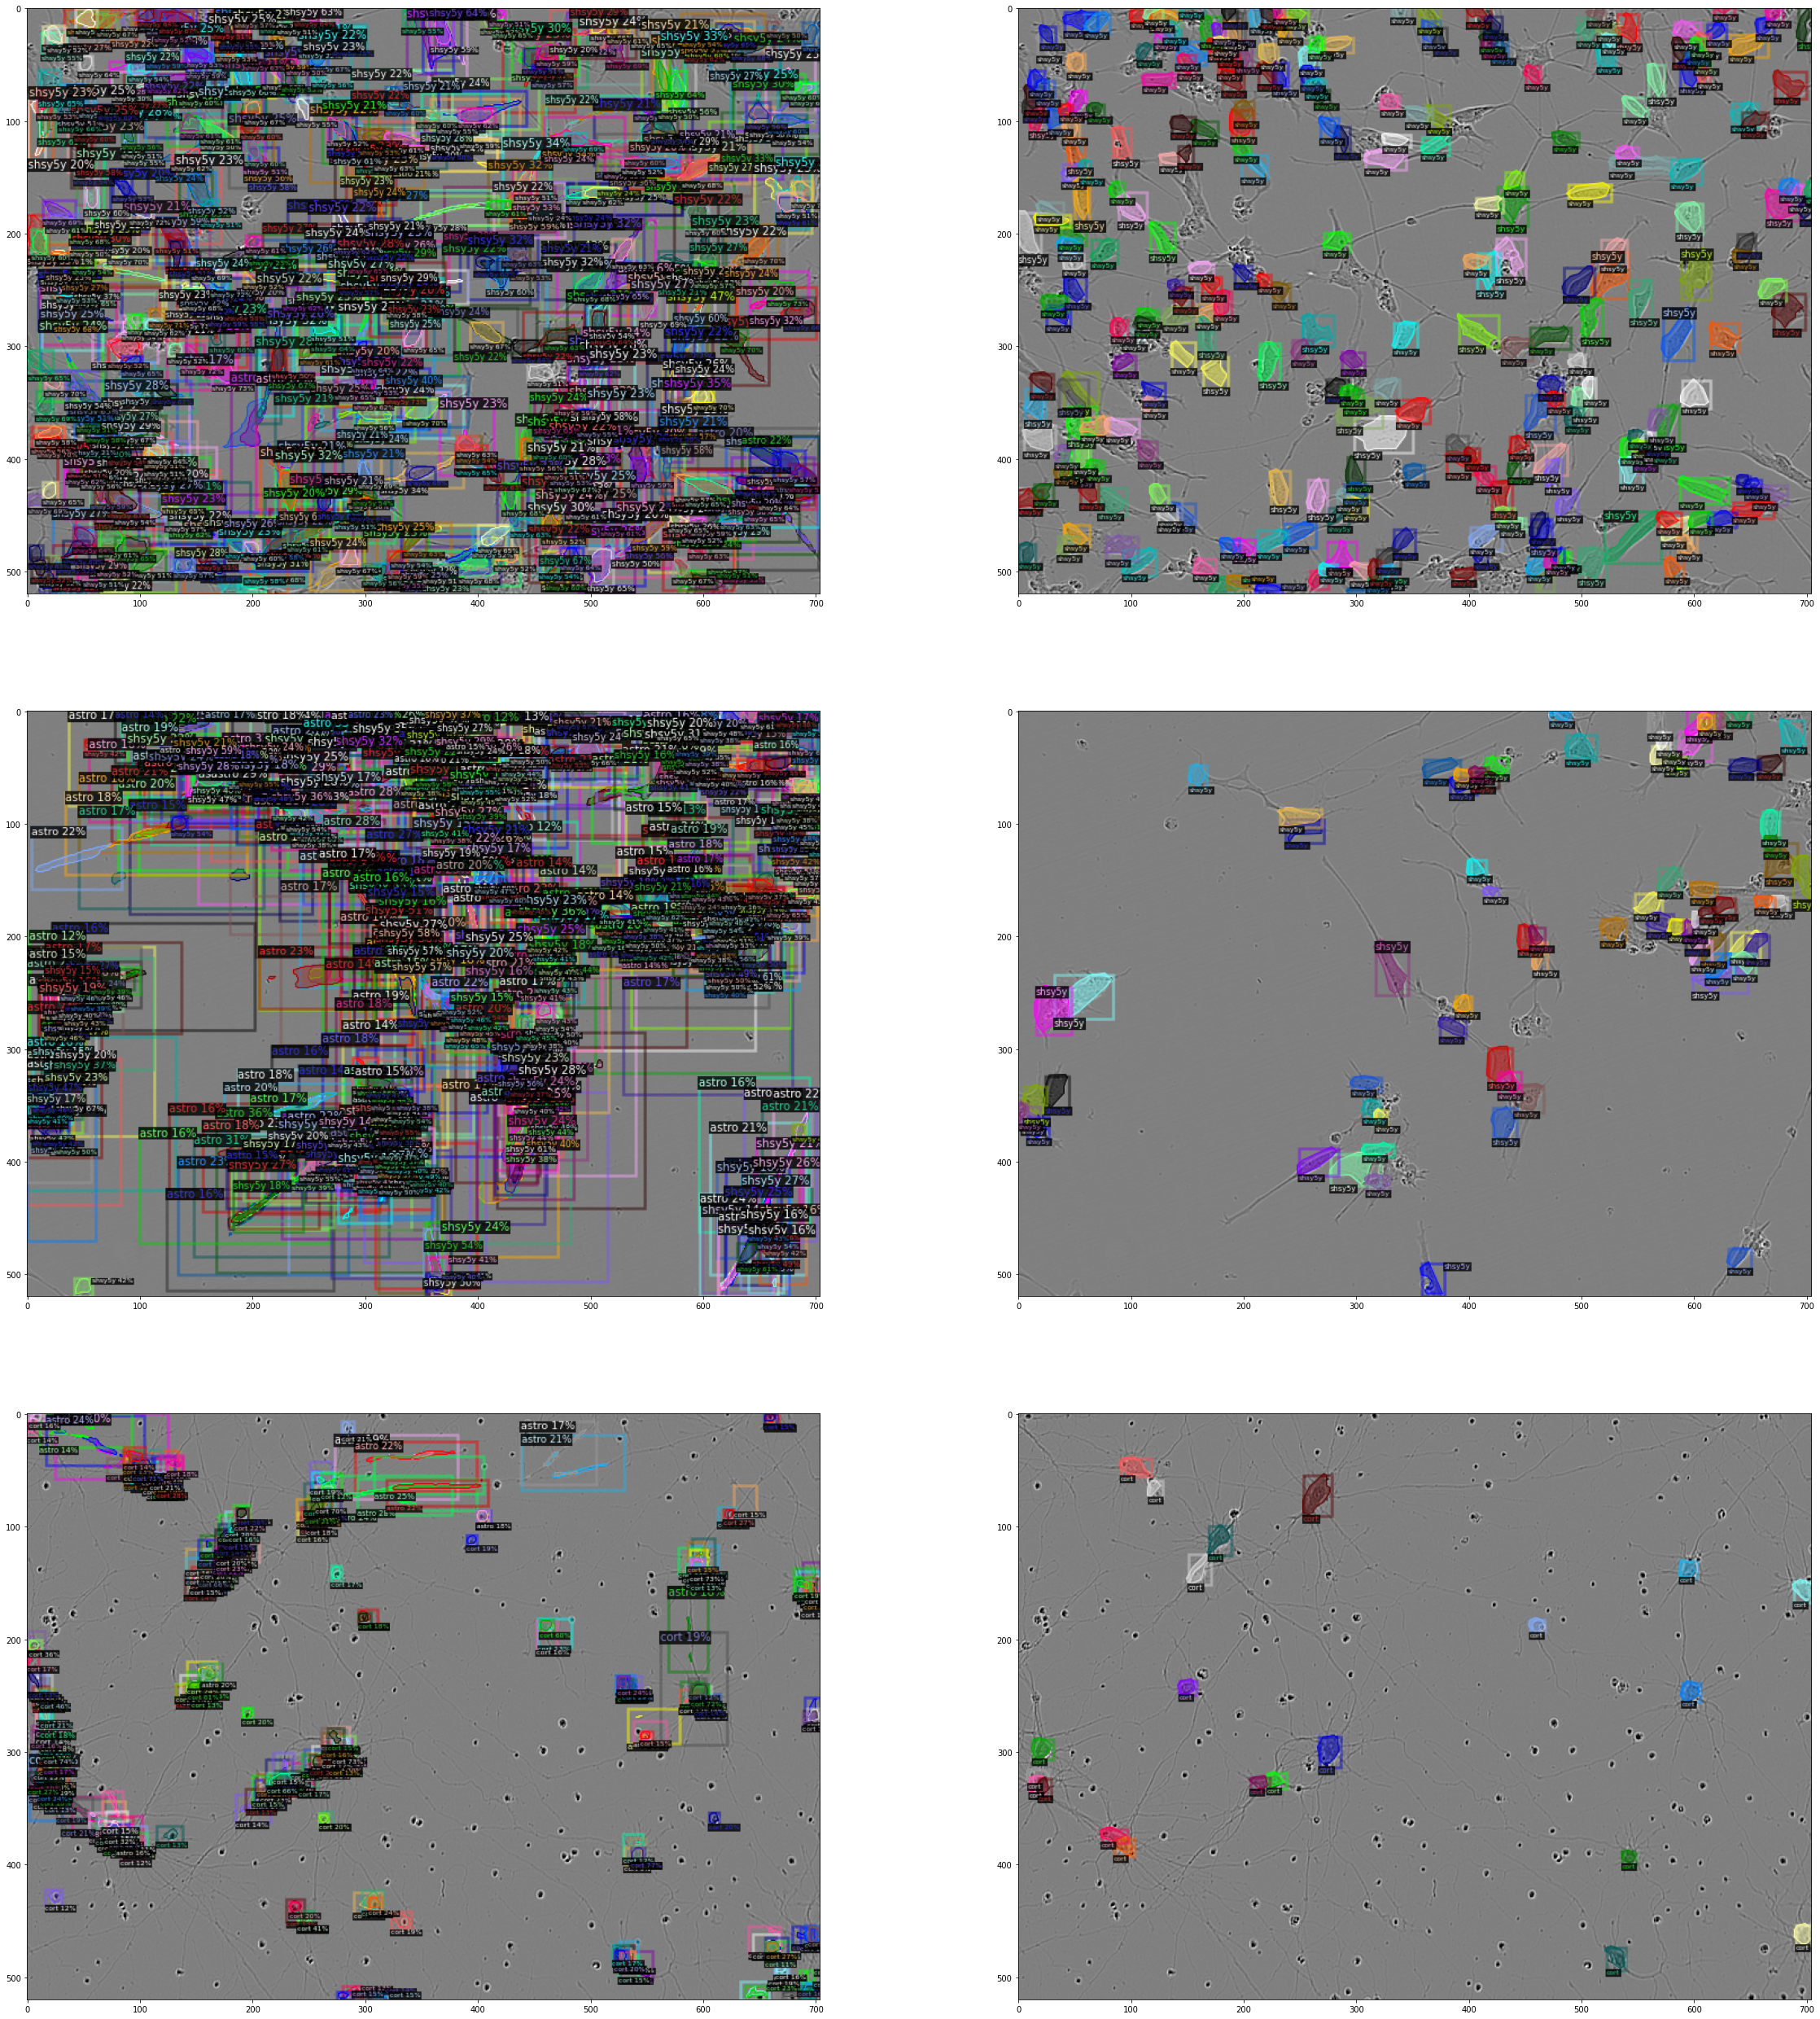

In [11]:
import random

cfg.defrost()
cfg.MODEL.WEIGHTS = './output/model_final.pth'  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('test')
outs = []
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('test'), 
                    
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('test'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(40,45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])

#### References
  
@inproceedings{lee2019energy,  
  title = {An Energy and GPU-Computation Efficient Backbone Network for Real-Time Object Detection},  
  author = {Lee, Youngwan and Hwang, Joong-won and Lee, Sangrok and Bae, Yuseok and Park, Jongyoul},  
  booktitle = {Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops},  
  year = {2019} 
}  

@inproceedings{lee2020centermask,  
  title={CenterMask: Real-Time Anchor-Free Instance Segmentation},  
  author={Lee, Youngwan and Park, Jongyoul},  
  booktitle={CVPR},  
  year={2020}  
}  